# Cython

https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html

In [1]:
%pylab inline
import pandas as pd

# Generate big data
n = 1000_000
data = {'a':np.random.randn(n),
       'b':np.random.randn(n),
       'N':np.random.randint(100,1000,(n,)),
       'cat':np.random.choice(['ABC','EFG','HIG'], size=(n,))}

df = pd.DataFrame(data)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def f(x):
    return x * (x - 1)


def integrate_f(a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx

In [3]:
plain_py = %timeit -o df.apply(lambda x: integrate_f(x[0],x[1],x[2]), axis=1)

53.6 s ± 366 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Plain Cython version

In [4]:
%load_ext cython

First we try the normal loop 

In [5]:
%%cython --annotate

cdef double f_cy(double x):
    return x * (x-1)

cpdef double integrate_f_cy(double a,double b,int N):
    cdef double s = 0.
    cdef double dx = (b-a)/N
    cdef int i = 0
    for i in range(N):
        s += f_cy(a + i * dx)
    return s * dx

In [7]:
plain_cy = %timeit -o df.apply(lambda x: integrate_f_cy(x[0],x[1],x[2]), axis=1)

6.16 s ± 71.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


There is a clear improvement but I can do faster!

## Numpy Array Cython verion

In [8]:
a,b,N = df.a.values, df.b.values, df.N.values
df.dtypes

a      float64
b      float64
N        int64
cat     object
dtype: object

In [9]:
%reload_ext cython

In [10]:
%%cython
import numpy as np
cimport numpy as np

DTYPE='float64'

ctypedef np.ndarray array

cdef double f_cy(double x):
    return x * (x-1)


cdef double integrate_f_cy(double a,double b,int N):
    cdef double s = 0.
    cdef double dx = (b-a)/N
    cdef int i = 0
    for i in range(N):
        s += f_cy(a + i * dx)
    return s * dx

def integrate_cy_np(col_a, col_b, col_N):
    cdef Py_ssize_t s = col_a.shape[0]
    assert col_a.shape == col_b.shape == col_N.shape
    assert col_a.dtype == col_b.dtype == DTYPE
    results = np.empty((s), dtype=DTYPE)
    cdef int i
    for i in range(s):
        results[i] = integrate_f_cy(col_a[i],col_b[i],col_N[i])
    return results

In [11]:
numpy_cy = %timeit -o integrate_cy_np(a,b,N)

548 ms ± 4.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is huge improvement from Python's 53 seconds and even from Cython's plain 6 seconds!
But we can even go faster

In [12]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

DTYPE='float64'


cdef double f_cy(double x):
    return x * (x-1)


cdef double integrate_f_cy(double a,double b, int N):
    cdef double s = 0.
    cdef double dx = (b-a)/N
    cdef int i = 0
    for i in range(N):
        s += f_cy(a + i * dx)
    return s * dx

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cpdef compute(double[:] col_a,double[:] col_b,long[:] col_N):
    #First define the memeory view index for 1D array as dtype[:], 2D array as dtype[:,:]..and so on
    cdef Py_ssize_t a_size = col_a.shape[0]
    # define the size of the array as Py_ssize_t (standard size object)
    
#     assert col_a.shape == col_b.shape == col_N.shape
#     assert col_a.dtype == col_b.dtype == DTYPE
    # assert that the sizes and datatypes are correct
    
    results = np.zeros((a_size,), dtype=DTYPE)
    # define an empty array to host your calculations
    
    cdef double[:] results_view = results
    # define a memory view fo the results: dtype[:] if your resutls are one array
    cdef Py_ssize_t i
    for i in range(a_size):
        results_view[i] = integrate_f_cy(col_a[i],col_b[i],col_N[i])
    return results

In [13]:
numpy_mem_view = %timeit -o compute(a,b,N)

433 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Conclusion**:
We went from 

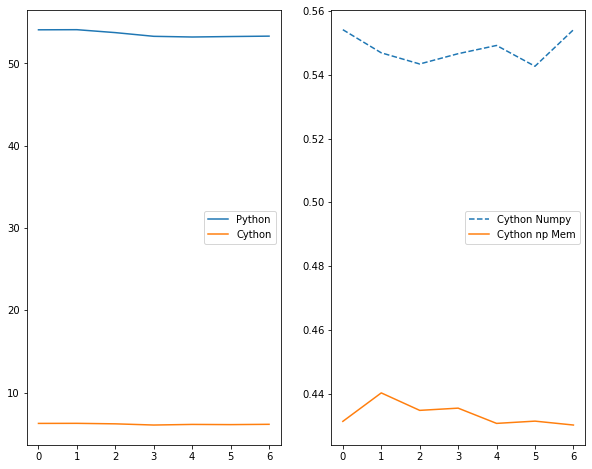

In [27]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(10,8))

ax1.plot(plain_py.timings, label='Python')
ax1.plot(plain_cy.timings, label='Cython')
ax2.plot(numpy_cy.timings, '--',label='Cython Numpy')
ax2.plot(numpy_mem_view.timings, label='Cython np Mem')
ax1.legend()
ax2.legend()
plt.show()